In [ ]:
!unzip "/content/drive/MyDrive/NG Hack Week/CASIA2.0_Groundtruth.zip"

In [ ]:
!unzip "/content/drive/MyDrive/NG Hack Week/CASIA2.0_revised.zip"

In [42]:
#Importing all the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import random
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image, ImageChops, ImageEnhance
from IPython.display import display # to display images


# New Section

In [4]:
# Reading a smaller portion of dataset
df = pd.read_csv('/content/drive/MyDrive/NG Hack Week/hundred.csv')
df.head()

,source,target,tampered
0,Au_ani_00044.jpg,Tp_S_NNN_S_B_ani00044_ani00044_00164_gt.png,Tp_S_NNN_S_B_ani00044_ani00044_00164.tif
1,Au_pla_20019.jpg,Tp_S_NRD_S_N_pla20019_pla20019_02390_gt.png,Tp_S_NRD_S_N_pla20019_pla20019_02390.tif
2,Au_sec_00057.jpg,Tp_D_NRD_M_N_sec00057_nat00001_00078_gt.png,Tp_D_NRD_M_N_sec00057_nat00001_00078.tif
3,Au_art_00070.jpg,Tp_S_NNN_S_B_art00070_art00070_01241_gt.png,Tp_S_NNN_S_B_art00070_art00070_01241.tif
4,Au_nat_20039.jpg,Tp_D_NRD_S_B_nat20039_arc20055_02239_gt.png,Tp_D_NRD_S_B_nat20039_arc20055_02239.tif


In [11]:
total_original = df['source']
total_tampered = df['tampered']
len(total_original)

1100

In [6]:
#https://gist.github.com/cirocosta/33c758ad77e6e6531392
#error level analysis of an image
def ELA(img_path):
    """Performs Error Level Analysis over a directory of images"""
    
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            # print(d[x,y])
            d[x, y] = tuple(k * SCALE for k in d[x, y])

    return diff


In [ ]:
orig_img = Image.open('/content/CASIA2.0_revised/Au/Au_ani_00001.jpg')
display(orig_img)

In [ ]:
ELA('/content/CASIA2.0_revised/Au/Au_ani_00001.jpg')

In [ ]:
tampered_img = Image.open('/content/CASIA2.0_revised/Tp/Tp_S_NRD_S_N_ani00001_ani00001_00014.tif')
display(tampered_img)

In [ ]:
ELA('/content/CASIA2.0_revised/Tp/Tp_S_NRD_S_N_ani00001_ani00001_00014.tif')

In [7]:
path_original = '/content/CASIA2.0_revised/Au/'
path_tampered = '/content/CASIA2.0_revised/Tp/'

# total_original = os.listdir(path_original)
# total_tampered = os.listdir(path_tampered)

In [12]:
len(total_original)

1100

In [13]:
len(total_tampered)

1100

In [14]:
images = []

for file in total_original:
# for file in os.listdir(path_original):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_original + file).st_size) > 10000:
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)



In [15]:
for file in total_tampered:
# for file in os.listdir(path_tampered):
    try:
        if file.endswith('jpg'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
        if file.endswith('tif'):
            if int(os.stat(path_tampered + file).st_size) > 10000:
                    line = path_tampered + file + ',1\n'
                    images.append(line)
    except:
          print(path_tampered+file)



In [16]:
len(images)

2131

In [17]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

100%|██████████| 2131/2131 [00:00<00:00, 275000.36it/s]


In [18]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

In [19]:
dataset['class_label'].value_counts()


1    1100
0    1031
Name: class_label, dtype: int64

In [ ]:
dataset.head()

,image,class_label
0,/content/CASIA2.0_revised/Au/Au_ani_00044.jpg,0
1,/content/CASIA2.0_revised/Au/Au_pla_20019.jpg,0
2,/content/CASIA2.0_revised/Au/Au_sec_00057.jpg,0
3,/content/CASIA2.0_revised/Au/Au_art_00070.jpg,0
4,/content/CASIA2.0_revised/Au/Au_nat_20039.jpg,0


In [20]:
dataset.to_csv('dataset_casa2.csv',index=False)

In [21]:
dataset = pd.read_csv('dataset_casa2.csv')

In [23]:
len(dataset)

2131

In [22]:
x_casia = []
y_casia = []

Below takes a while

In [24]:
for _, row in dataset.iterrows():
    x_casia.append(np.array(ELA(row[0]).resize((128, 128))).flatten() / 255.0)
    y_casia.append(row[1])

In [25]:
#converting X and Y to numpy arrays
x_casia = np.array(x_casia)
y_casia = np.array(y_casia)


In [26]:
x_casia = x_casia.reshape(-1, 128, 128, 3)
x_casia[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [27]:
y_casia = to_categorical(y_casia, 2) #y is one hot encoded
y_casia[0] 

array([1., 0.], dtype=float32)

In [28]:
len(x_casia)

2131

In [29]:
from numpy import save
## save all the data 
save('X_casia.npy', x_casia)
save('Y_casia.npy',y_casia)

In [30]:
from numpy import load
x_casia = load('X_casia.npy')
y_casia = load('Y_casia.npy')

In [31]:
X_train, X_val, Y_train, Y_val = train_test_split(x_casia, y_casia, test_size = 0.2, random_state=5)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [32]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [33]:
optimizer = Adam()

In [34]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [38]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

In [44]:
os.makedirs('model_checkpoints')
# define callbacks for learning rate scheduling and best checkpoints saving
filepath = 'model_checkpoints/model_phase_2.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_metric',save_best_only=True, mode='max')

In [45]:
history = model.fit(X_train, Y_train, batch_size = 100, epochs = 10, 
          validation_data = (X_val, Y_val), verbose = 1, callbacks=[early_stopping])

Epoch 1/10
18/18 [==============================] - 187s 10s/step - loss: 0.5660 - accuracy: 0.6978 - val_loss: 0.5723 - val_accuracy: 0.7049
Epoch 2/10
18/18 [==============================] - 184s 10s/step - loss: 0.5299 - accuracy: 0.7277 - val_loss: 0.5889 - val_accuracy: 0.6815
Epoch 3/10
18/18 [==============================] - 183s 10s/step - loss: 0.4634 - accuracy: 0.7612 - val_loss: 0.5443 - val_accuracy: 0.7026
Epoch 4/10
18/18 [==============================] - 185s 10s/step - loss: 0.4332 - accuracy: 0.7746 - val_loss: 0.5211 - val_accuracy: 0.7283
Epoch 5/10
18/18 [==============================] - 182s 10s/step - loss: 0.3621 - accuracy: 0.8345 - val_loss: 0.6147 - val_accuracy: 0.7096
Epoch 6/10
18/18 [==============================] - 185s 10s/step - loss: 0.3246 - accuracy: 0.8468 - val_loss: 0.5689 - val_accuracy: 0.7494
Epoch 6: early stopping


Get to after .save to saveeeeeee

In [46]:
model.save('new_model_casia.h5')

[0, 1, 2, 3, 4]
[0.5660350322723389, 0.5298526883125305, 0.463440865278244, 0.4332418739795685, 0.3620733916759491, 0.3245522677898407]


ValueError: ignored

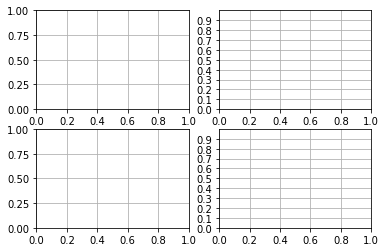

In [47]:
fig = plt.figure()
p1 = fig.add_subplot(221)
p2 = fig.add_subplot(222)
p3 = fig.add_subplot(223)
p4 = fig.add_subplot(224)
p2.set_ylim(0,1)
p4.set_ylim(0,1)
p1.grid()
p2.grid()
p3.grid()
p4.grid()
p2.set_yticks(np.arange(0,1,0.1))
p4.set_yticks(np.arange(0,1,0.1))
x = [i for i in range(5)]
y = history.history['loss']

print(x)
print(y)

y2 = history.history['accuracy']
y3 = history.history['val_loss']
y4 = history.history['val_accuracy']
p1.plot(x,y, 'r', label='train_loss')
p1.legend()
p2.plot(x,y2, 'b', label='train_accuracy')
p2.legend()
p3.plot(x,y3, 'r', label='val_loss')
p3.legend()
p4.plot(x,y4, 'b', label='val_accuracy')
p4.legend()
plt.show()

In [51]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
y_pred_cnn = model.predict(X_val)
y_pred_cnn = np.argmax(y_pred_cnn,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

score = metrics.precision_score(Y_true,y_pred_cnn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred_cnn, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true, y_pred_cnn, average= "weighted")
print("F1 score: {}".format(score_lr1))
X_val

14/14 [==============================] - 11s 765ms/step
Precision score: 0.7531027616558623
Recall score: 0.7494145199063232
F1 score: 0.7482203672089297


array([[[[0.01960784, 0.03529412, 0.01176471],
         [0.02352941, 0.02352941, 0.        ],
         [0.03921569, 0.02352941, 0.01960784],
         ...,
         [0.00784314, 0.00784314, 0.02745098],
         [0.01960784, 0.02352941, 0.05098039],
         [0.03529412, 0.04313725, 0.08627451]],

        [[0.0627451 , 0.03137255, 0.01176471],
         [0.05490196, 0.03529412, 0.00784314],
         [0.05490196, 0.01960784, 0.00784314],
         ...,
         [0.01176471, 0.01568627, 0.06666667],
         [0.00784314, 0.01176471, 0.03921569],
         [0.01176471, 0.01176471, 0.01960784]],

        [[0.04705882, 0.02352941, 0.01960784],
         [0.05098039, 0.02352941, 0.00784314],
         [0.04705882, 0.01960784, 0.01960784],
         ...,
         [0.00784314, 0.02352941, 0.02745098],
         [0.00392157, 0.01176471, 0.01568627],
         [0.        , 0.00392157, 0.00392157]],

        ...,

        [[0.0627451 , 0.03137255, 0.03921569],
         [0.05490196, 0.01960784, 0.04313725]

Confusion matrix:
 [[144  67]
 [ 40 176]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       211
           1       0.72      0.81      0.77       216

    accuracy                           0.75       427
   macro avg       0.75      0.75      0.75       427
weighted avg       0.75      0.75      0.75       427

Plot of Confusion Matrix


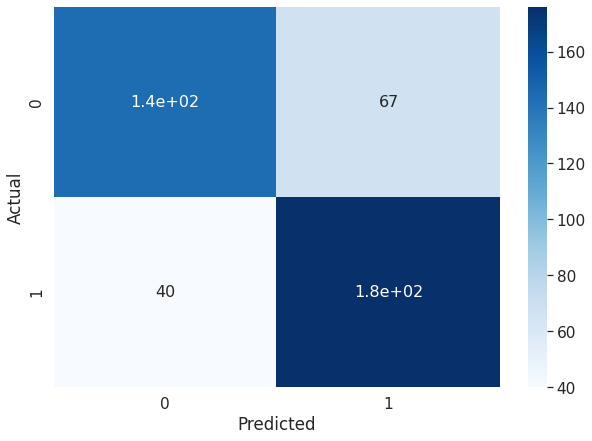

In [49]:
import seaborn as sns
cm = confusion_matrix(Y_true, y_pred_cnn)
print('Confusion matrix:\n',cm)

print(classification_report(Y_true, y_pred_cnn))

print('Plot of Confusion Matrix')
df_cm = pd.DataFrame(cm, columns=np.unique(Y_true), index = np.unique(Y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [50]:
from sklearn.metrics import roc_auc_score
print('ROC_AUC score:',roc_auc_score(Y_true,y_pred_cnn))
df_cm

ROC_AUC score: 0.748639634895559


Predicted,0,1
Actual,,
0,144,67
1,40,176
